In [1]:
import numpy as np
import pandas as pd
import copy
import galsim
import piff
from piff.star import Star, StarFit, StarData
from donutlib.makedonut import makedonut

# this needs to go after piff, since it resets matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
print(piff.__version__)
print(galsim.__version__)

0.4
2.3


# Make donuts with donutlib and PIFF, and compare shapes

In [3]:
def donut_calc(zarray):
    donut_zarray = [0,0,0]+zarray
    donutDict = {'writeToFits':False,
                 'iTelescope':0,    # for DECam
                 'nZernikeTerms':37,
                 'nbin':512,
                 'nPixels':64,
                 'pixelOverSample':8,
                 'scaleFactor':1.0,
                 'rzero':0.14,
                 'nEle':1.0e0, 
                 'background':0., 
                 'randomFlag':False,
                 'randomSeed':1234567890, 
                 'xDECam': 118.,'yDECam' :128. , #in sensor N24
                 'ZernikeArray':donut_zarray}
    return makedonut(**donutDict).make()

In [4]:
# Piff Configuration
# This function creates the config for a psf

def return_config():
    return {
        'type': 'OptAtmo',
        'optical_psf_kwargs': {
            'template': 'des',  # was 'des_vonkarman' not available now
            'pad_factor' : 8.0,   # must include and set to 8 for donuts
        },
        'reference_wavefront': None,
        'n_optfit_stars': 0,
        'fov_radius': 4500.,
        'jmax_pupil': 21,  # was 37
        'jmax_focal': 1,   # was 3
        'min_optfit_snr': 0,
        'higher_order_reference_wavefront_file': None,
        'init_with_rf' : False,
        'random_forest_shapes_model_pickles_location': None,
        'optatmo_psf_kwargs':
            {
                'size': 1.0,
                'g1': 0.0,
                'g2': 0.0,
                'L0': 25., 
                'fix_size': False,
                'fix_g1': False,
                'fix_g2': False,
                'fix_L0': False,
                'fix_zPupil004_zFocal001': False,  
                'fix_zPupil005_zFocal001': False,  
                'fix_zPupil006_zFocal001': False,   
                'fix_zPupil007_zFocal001': False,   
                'fix_zPupil008_zFocal001': False,  
                'fix_zPupil009_zFocal001': False,    
                'fix_zPupil010_zFocal001': False,  
                'fix_zPupil011_zFocal001': False,  
                'fix_zPupil012_zFocal001': False,    
                'fix_zPupil013_zFocal001': False,  
                'fix_zPupil014_zFocal001': False,  
                'fix_zPupil015_zFocal001': False,  
                'fix_zPupil016_zFocal001': False,  
                'fix_zPupil017_zFocal001': False,  
                'fix_zPupil018_zFocal001': False,  
                'fix_zPupil019_zFocal001': False,  
                'fix_zPupil020_zFocal001': False,  
                'fix_zPupil021_zFocal001': False,  
                'fix_zPupil022_zFocal001': False
            },
        'atmo_interp': 'none',
        'reference_wavefront_zernikes_list': list(range(4,12)),
        'higher_order_reference_wavefront_zernikes_list': list(range(12,22+1)),
        'atmosphere_model': 'vonkarman', 
    }


In [5]:
# This function creates a blank star given a chipnum and a location.
def make_blank_star(x, y, chipnum, properties={}, **kwargs):
    decaminfo = piff.des.DECamInfo()    
    wcs = decaminfo.get_nominal_wcs(chipnum)
    properties_in = {'chipnum': chipnum}
    properties_in.update(properties)
    star = piff.Star.makeTarget(x=x, y=y, wcs=wcs, stamp_size=64, properties=properties_in, **kwargs)
    return star

In [6]:
# make one star from Piff OptAtmo

def piff_calc(zarray):
    
    chipnum = 10
    icen = 500
    jcen = 500
    blank_star = make_blank_star(icen,jcen,chipnum)

    config = return_config()
    aopsf = piff.PSF.process(config)
    
    chipnum = 10
    icen = 500
    jcen = 500
    blank_star = make_blank_star(icen,jcen,chipnum)

    # fit_params is: atmo_size, atmo_g1, atmo_g2, L0, opt_size, opt_g1, opt_g2, z4, z5, z6, z7, z8, z9, z10, z11 to z22
    fit_params = np.zeros(26)
    default_params = np.array([0.0,0.0,0.0,25.,0.7,0.0,0.0])
    fit_params[0:7] = default_params
    for iZ in range(len(zarray)):
        fit_params[7+iZ] = zarray[iZ]
    #print(fit_params)

    prof = aopsf.getProfile(copy.deepcopy(blank_star),fit_params)  #a Profile is a GalSim object that knows *how* to be drawn, here it is the convoluation of OpticalPSF and VonKarman
    noiseless_star = aopsf.drawProfile(blank_star, prof, fit_params)   # this draws the Profile into a Star object
    noiseless_image = noiseless_star.image

    return noiseless_image


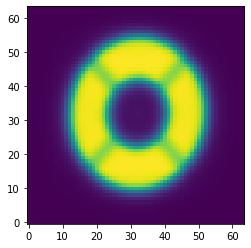

In [9]:
# test piff_calc
zarray = np.array([12.0,0.2,1.])
noiseless_image = piff_calc(zarray)
f,ax = plt.subplots(1,1)
ax.imshow(noiseless_image.array,origin='lower',interpolation='None')

12.00, 0.13, -0.25, 0.04, 0.14, -0.19, 0.01, 0.02, -0.08, -0.10, -0.02, -0.03, -0.05, 0.20, 0.05, 0.10, 0.07, 0.00
12.00, 0.20, -0.07, -0.04, -0.14, -0.12, 0.01, -0.20, 0.08, 0.02, 0.11, -0.28, 0.05, 0.01, -0.09, -0.23, -0.01, -0.04
12.00, 0.14, 0.01, -0.06, 0.01, -0.10, 0.02, -0.01, 0.05, 0.06, -0.02, -0.02, -0.06, -0.04, 0.10, -0.08, -0.09, 0.05
12.00, 0.14, 0.04, 0.01, -0.05, 0.12, -0.15, 0.12, 0.16, 0.01, 0.01, -0.09, -0.08, -0.16, 0.06, 0.08, 0.20, -0.08
12.00, -0.04, -0.01, 0.07, -0.14, -0.04, -0.10, 0.01, 0.09, -0.05, 0.08, 0.11, -0.02, 0.15, -0.07, -0.07, 0.11, -0.07
12.00, -0.11, 0.12, 0.02, 0.03, -0.10, 0.05, 0.01, 0.07, -0.18, 0.14, -0.06, -0.02, 0.03, 0.07, 0.03, -0.07, -0.11
12.00, 0.13, 0.06, 0.07, 0.20, 0.08, 0.06, 0.24, 0.08, 0.18, 0.07, 0.05, -0.02, -0.09, 0.13, -0.08, 0.11, -0.07
12.00, 0.12, 0.07, 0.09, -0.11, -0.08, -0.06, 0.17, 0.00, 0.08, -0.13, -0.10, -0.13, -0.07, 0.02, -0.22, 0.00, -0.01
12.00, 0.09, 0.00, -0.13, -0.19, -0.13, -0.09, -0.03, 0.05, -0.15, -0.07, 

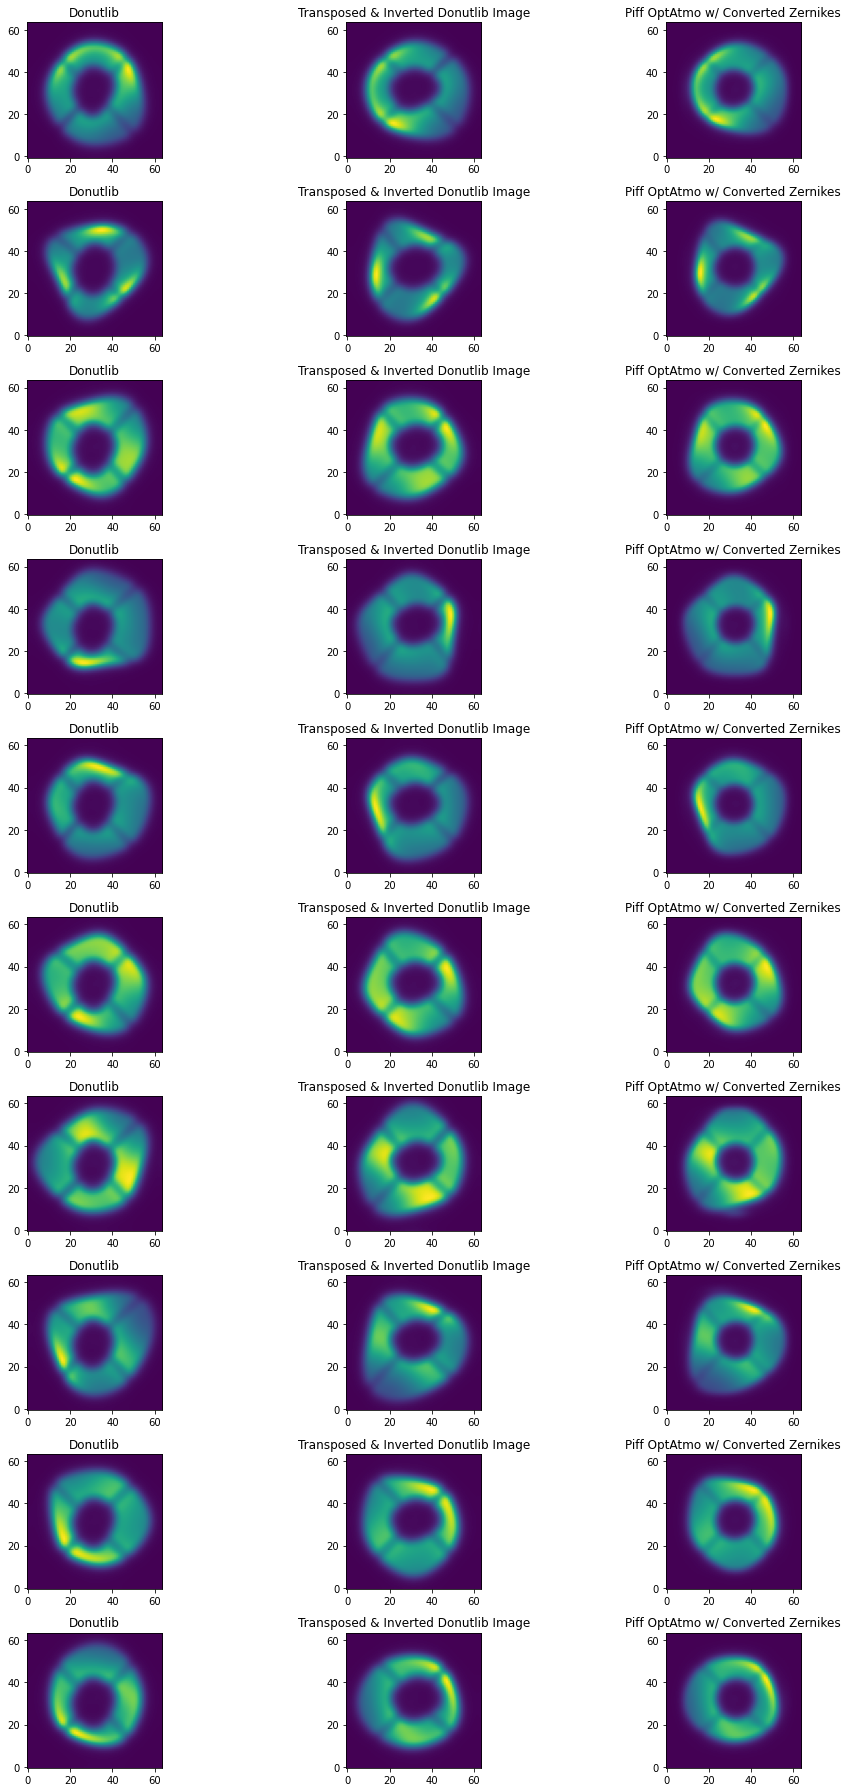

In [10]:
# compare donutlib vs. piff, 
# start with donutlib image which is in (x,y), 
# flip&transpose to make image look as it should in (u,v)
# then compare against Piff image also in (u,v)
# 
# the latter two columns should  now match!

gd = galsim.GaussianDeviate(12345)
z4 = 12.0
fig, axes = plt.subplots(10, 3, figsize=(15, 25))
for i in range(10):
    # Add Gaussian-distributed aberrations
    zarray_ran = np.empty((17,), float)
    gd.generate(zarray_ran)
    zarray = [z4]+list(0.1*zarray_ran)
    
    print(', '.join(f'{q:.2f}' for q in zarray))
    
    donut_image = donut_calc(zarray)
    piff_image_zconvert = piff_calc(zarray)
    axes[i, 0].imshow(donut_image,origin='lower')
    axes[i, 1].imshow(np.transpose(np.flip(donut_image)),origin='lower') # should be correct
    axes[i, 2].imshow(piff_image_zconvert.array,origin='lower')

    axes[i, 0].set_title("Donutlib")
    axes[i, 1].set_title("Transposed & Inverted Donutlib Image")
    axes[i, 2].set_title("Piff OptAtmo w/ Converted Zernikes")

fig.tight_layout()



In [11]:
print(galsim.__file__)

/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.7/site-packages/GalSim-2.3-py3.7-linux-x86_64.egg/galsim/__init__.py


in phase_psf.py I just changed to this line:
> ftexpwf = fft.ifft2(expwf_grid, shift_in=True, shift_out=True)